### Imports básicos

In [1]:
import requests
from bs4 import BeautifulSoup
import math
import random
from nltk.tokenize import word_tokenize
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
games_df = pd.read_csv('games.csv', index_col=0)

In [3]:
pbp_df = pd.read_csv('PBP.csv', index_col=0)

Trazendo e tratando a a tabela de trabalho

In [4]:
merge_df = pd.read_csv('merge_df.csv', index_col=0)

In [5]:
# Função para limpar os nomes
def processing_text(text):
    
    text = text.replace('(', '').replace(')', '').replace(".",'').replace(".."
                    , '').replace(";", '').lower().replace('da silva', 'dasilva')
    
    text = word_tokenize(text)
    
    return text

In [6]:
merge_df['clean_play'] = merge_df['play'].apply(processing_text)
merge_df

,key,quarter,time,score,team_play,play,away_team,home_team,clean_play
0,/boxscores/pbp/202410300CHI.html,Q1,11:44.0,3-0,Orlando Magic,K. Caldwell-Pope makes 3-pt jump shot from 26 ...,Orlando Magic,Chicago Bulls,"[k, caldwell-pope, makes, 3-pt, jump, shot, fr..."
1,/boxscores/pbp/202410300CHI.html,Q1,11:27.0,3-2,Chicago Bulls,J. Giddey makes 2-pt jump shot from 20 ft,Orlando Magic,Chicago Bulls,"[j, giddey, makes, 2-pt, jump, shot, from, 20,..."
2,/boxscores/pbp/202410300CHI.html,Q1,11:15.0,3-2,Orlando Magic,P. Banchero misses 2-pt jump shot from 6 ft,Orlando Magic,Chicago Bulls,"[p, banchero, misses, 2-pt, jump, shot, from, ..."
3,/boxscores/pbp/202410300CHI.html,Q1,11:12.0,3-2,Chicago Bulls,Defensive rebound by J. Giddey,Orlando Magic,Chicago Bulls,"[defensive, rebound, by, j, giddey]"
4,/boxscores/pbp/202410300CHI.html,Q1,11:01.0,3-2,Chicago Bulls,P. Williams misses 2-pt layup from 2 ft,Orlando Magic,Chicago Bulls,"[p, williams, misses, 2-pt, layup, from, 2, ft]"
...,...,...,...,...,...,...,...,...,...
31152,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,125-121,Memphis Grizzlies,D. Bane makes free throw 1 of 2,Memphis Grizzlies,Utah Jazz,"[d, bane, makes, free, throw, 1, of, 2]"
31153,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,126-121,Memphis Grizzlies,D. Bane makes free throw 2 of 2,Memphis Grizzlies,Utah Jazz,"[d, bane, makes, free, throw, 2, of, 2]"
31154,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,126-121,Utah Jazz,Utah full timeout,Memphis Grizzlies,Utah Jazz,"[utah, full, timeout]"
31155,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,126-121,Utah Jazz,C. Sexton enters the game for W. Kessler,Memphis Grizzlies,Utah Jazz,"[c, sexton, enters, the, game, for, w, kessler]"


# Explorando os tipos de jogadas para criar as colunas da nossa base de dados

### Criando lista com todas as jogadas do dia para a exploração e funções para tratar os dados

In [7]:
#Criando uma lista com todas as jogadas do dia
plays_list = list(merge_df.play)

plays_list = [x.replace('(', '').replace(')', '').replace(".",
            '').replace("..", '').replace(";", '').lower() for x in plays_list]

plays_list

['k caldwell-pope makes 3-pt jump shot from 26 ft assist by p banchero',
 'j giddey makes 2-pt jump shot from 20 ft',
 'p banchero misses 2-pt jump shot from 6 ft',
 'defensive rebound by j giddey',
 'p williams misses 2-pt layup from 2 ft',
 'offensive rebound by n vučević',
 'p williams misses 3-pt jump shot from 26 ft',
 'defensive rebound by p banchero',
 'p banchero makes 2-pt jump shot from 22 ft assist by w carter',
 'c white misses 3-pt jump shot from 25 ft',
 'defensive rebound by p banchero',
 'f wagner makes 2-pt layup from 1 ft assist by p banchero',
 'n vučević misses 2-pt layup from 2 ft',
 'defensive rebound by p banchero',
 'p banchero makes 2-pt layup at rim',
 'j giddey misses 2-pt jump shot from 2 ft',
 'defensive rebound by j suggs',
 'j suggs misses 3-pt jump shot from 29 ft',
 'defensive rebound by p williams',
 'chicago full timeout',
 'z lavine misses 3-pt jump shot from 25 ft',
 'defensive rebound by j suggs',
 'w carter misses 3-pt jump shot from 25 ft',
 'def

In [8]:
# Função para separar jogadas que tenham a palavra desejada
from nltk.tokenize import word_tokenize

def wanted_word_list(words_list, wanted_word):
    
    wanted_list = [i for i in words_list if wanted_word in i]
    wanted_list = [word_tokenize(i) for i in wanted_list]
    
    return wanted_list

In [9]:
#Função para entender o número máximos de palavra de cada lista
from collections import Counter

def find_max_words(words_list):
    num_palavras = [len(sublista) for sublista in words_list]
    contagem = Counter(num_palavras)
    return max(contagem.keys())

In [10]:
#Função para criar colunas
def columns_def(max_w):
    columns_list = []
    for i in range(max_w):
        columns_list.append(f"word{i}")
    return columns_list

### Exploranddo as palavras que mais se repetem

In [11]:
plays_list_token = [word_tokenize(i) for i in plays_list]
plays_df = pd.DataFrame(plays_list_token)
plays_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,k,caldwell-pope,makes,3-pt,jump,shot,from,26,ft,assist,by,p,banchero
1,j,giddey,makes,2-pt,jump,shot,from,20,ft,None,None,None,None
2,p,banchero,misses,2-pt,jump,shot,from,6,ft,None,None,None,None
3,defensive,rebound,by,j,giddey,None,None,None,None,None,None,None,None
4,p,williams,misses,2-pt,layup,from,2,ft,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31152,d,bane,makes,free,throw,1,of,2,None,None,None,None,None
31153,d,bane,makes,free,throw,2,of,2,None,None,None,None,None
31154,utah,full,timeout,None,None,None,None,None,None,None,None,None,None
31155,c,sexton,enters,the,game,for,w,kessler,None,None,None,None,None


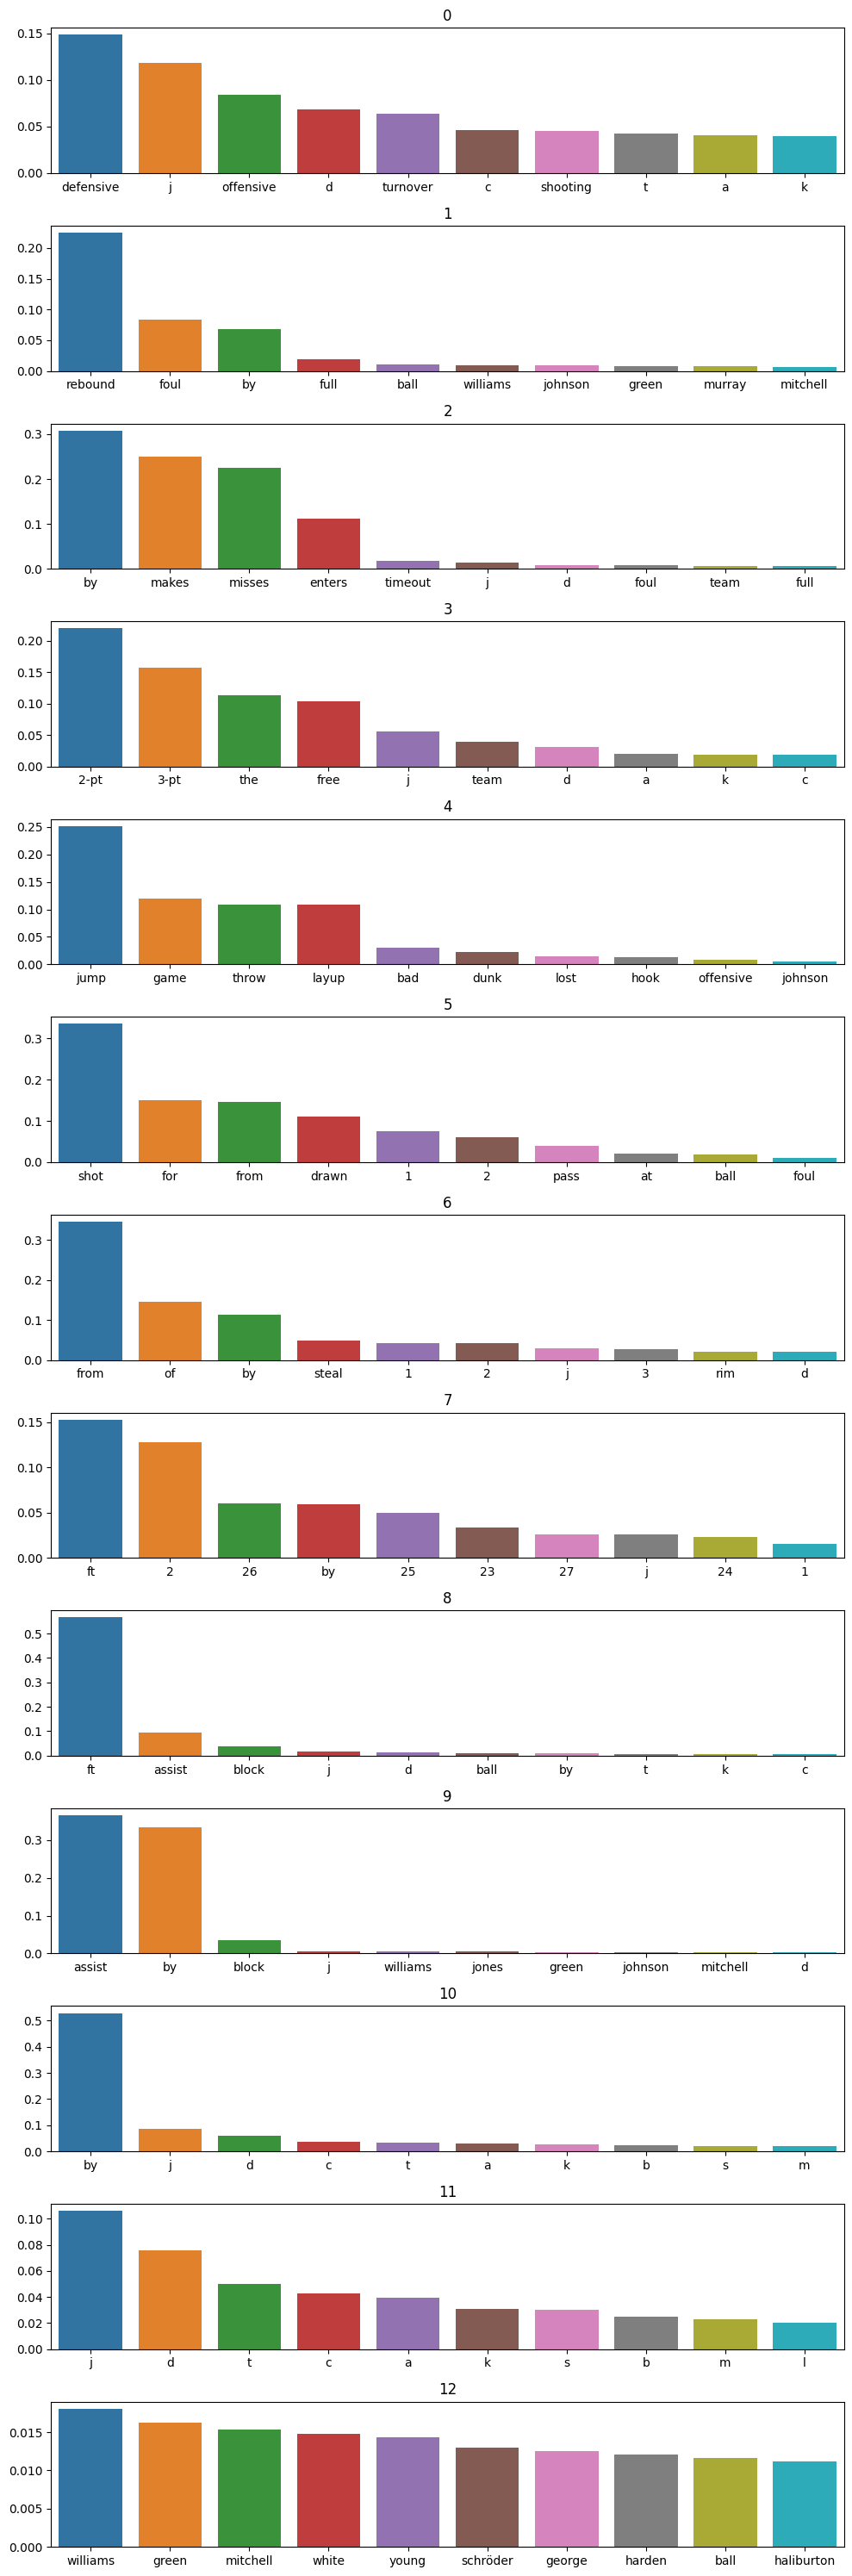

In [12]:
plays_col = plays_df.columns.to_list()
fig, axs = plt.subplots(nrows=len(plays_col), ncols=1, figsize=(10, 30))

# Loop para criar os gráficos
for n, col in enumerate(plays_col):
    
    # Não precisa converter o índice 'n' em índices de linha, já que row = n
    row = n  # Cada subplot em uma nova linha
    
    top5_words = plays_df[col].value_counts(normalize=True)[0:10]
    sns.barplot(x=top5_words.index, y=top5_words.values, ax=axs[row])
    axs[row].set_title(col)  # Adicione um título ao gráfico

plt.tight_layout()  # Para melhorar a disposição dos gráficos
plt.show()


In [13]:
top5_words = plays_df[0].value_counts(normalize=True)[0:10]
top5_words

defensive    0.148666
j            0.118625
offensive    0.084540
d            0.068299
turnover     0.063774
c            0.045864
shooting     0.044902
t            0.042270
a            0.040569
k            0.040087
Name: 0, dtype: float64

## Colunas iniciais

Criando o dicionário que servirá de base para a base de dados tabular do play-by-play

Todas as jogadas contarão com essa informaçoes

In [14]:
pbp_tab_data = {
    'key' : [],
    'quarter' : [],
    'time' : [],
    'team' : [],
    'player': [],
    'PTS': []
}

## Arremessos feitos

In [15]:
makes_list = wanted_word_list(plays_list, 'makes')
max_words_make_list = find_max_words(makes_list)
columns_make_list = columns_def(max_words_make_list)

In [16]:
makes_df = pd.DataFrame(makes_list, columns=columns_make_list)
makes_df

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,word11,word12
0,k,caldwell-pope,makes,3-pt,jump,shot,from,26,ft,assist,by,p,banchero
1,j,giddey,makes,2-pt,jump,shot,from,20,ft,None,None,None,None
2,p,banchero,makes,2-pt,jump,shot,from,22,ft,assist,by,w,carter
3,f,wagner,makes,2-pt,layup,from,1,ft,assist,by,p,banchero,None
4,p,banchero,makes,2-pt,layup,at,rim,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7780,k,george,makes,free,throw,1,of,2,None,None,None,None,None
7781,k,george,makes,free,throw,2,of,2,None,None,None,None,None
7782,d,bane,makes,free,throw,1,of,2,None,None,None,None,None
7783,d,bane,makes,free,throw,2,of,2,None,None,None,None,None


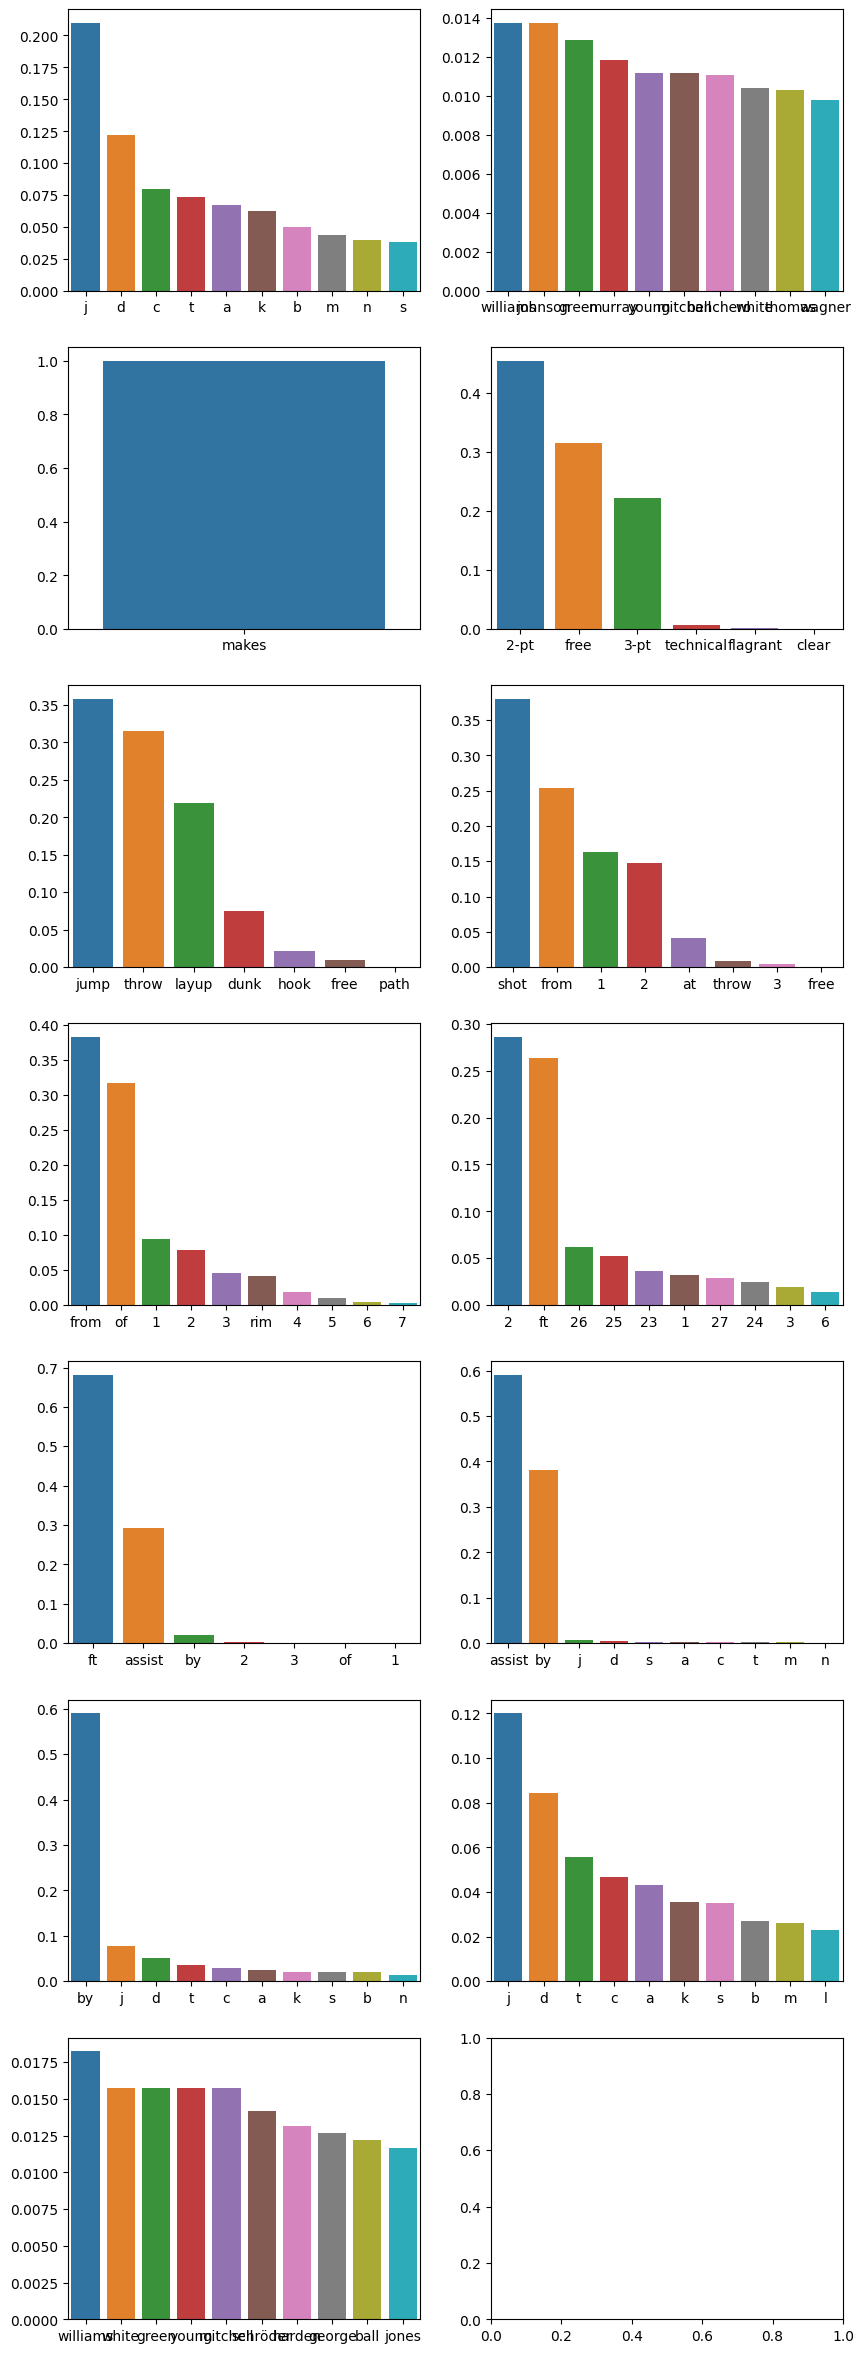

In [17]:
# # Configuração das subplots

fig, axs = plt.subplots(nrows=math.ceil(len(columns_make_list)/2), ncols=2, figsize=(10, 30))

# Loop para criar os gráficos
for n, col in enumerate(columns_make_list):
    
    # Converter o índice 'n' em índices de linha e coluna
    row = n // 2
    col_idx = n % 2
    
    top5_words = makes_df[col].value_counts(normalize=True)[0:10]
    sns.barplot(x=top5_words.index, y=top5_words.values, ax=axs[row, col_idx])



### Palavras a serem adicionadas

In [18]:
# Colunas necessárias 
pbp_tab_data['2PA'] = []
pbp_tab_data['2PM'] = []
pbp_tab_data['3PA'] = []
pbp_tab_data['3PM'] = []
pbp_tab_data['FTA'] = []
pbp_tab_data['FTM'] = []
pbp_tab_data['DUNK'] = []
pbp_tab_data['LAYUP'] = []
pbp_tab_data['HOOK'] = []
pbp_tab_data['JUMP'] = []
pbp_tab_data['shoot_dist'] = []
pbp_tab_data['AST'] = []
pbp_tab_data['AST_by'] = []
pbp_tab_data['AST_to'] = []
pbp_tab_data['technical'] = []
pbp_tab_data['flagrant'] = []
pbp_tab_data['clear_path'] = []

pbp_tab_data

{'key': [],
 'quarter': [],
 'time': [],
 'team': [],
 'player': [],
 'PTS': [],
 '2PA': [],
 '2PM': [],
 '3PA': [],
 '3PM': [],
 'FTA': [],
 'FTM': [],
 'DUNK': [],
 'LAYUP': [],
 'HOOK': [],
 'JUMP': [],
 'shoot_dist': [],
 'AST': [],
 'AST_by': [],
 'AST_to': [],
 'technical': [],
 'flagrant': [],
 'clear_path': []}

## Arremessos perdidos

In [19]:
misses_list = wanted_word_list(plays_list, 'misses')
max_words_miss_list = find_max_words(misses_list)
columns_misses_list = columns_def(max_words_miss_list)

In [20]:
misses_df = pd.DataFrame(misses_list, columns=columns_misses_list)
misses_df

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,word11,word12
0,p,banchero,misses,2-pt,jump,shot,from,6,ft,None,None,None,None
1,p,williams,misses,2-pt,layup,from,2,ft,None,None,None,None,None
2,p,williams,misses,3-pt,jump,shot,from,26,ft,None,None,None,None
3,c,white,misses,3-pt,jump,shot,from,25,ft,None,None,None,None
4,n,vučević,misses,2-pt,layup,from,2,ft,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7014,l,markkanen,misses,2-pt,layup,from,6,ft,None,None,None,None,None
7015,c,sexton,misses,free,throw,1,of,2,None,None,None,None,None
7016,c,sexton,misses,free,throw,2,of,2,None,None,None,None,None
7017,k,george,misses,free,throw,1,of,2,None,None,None,None,None


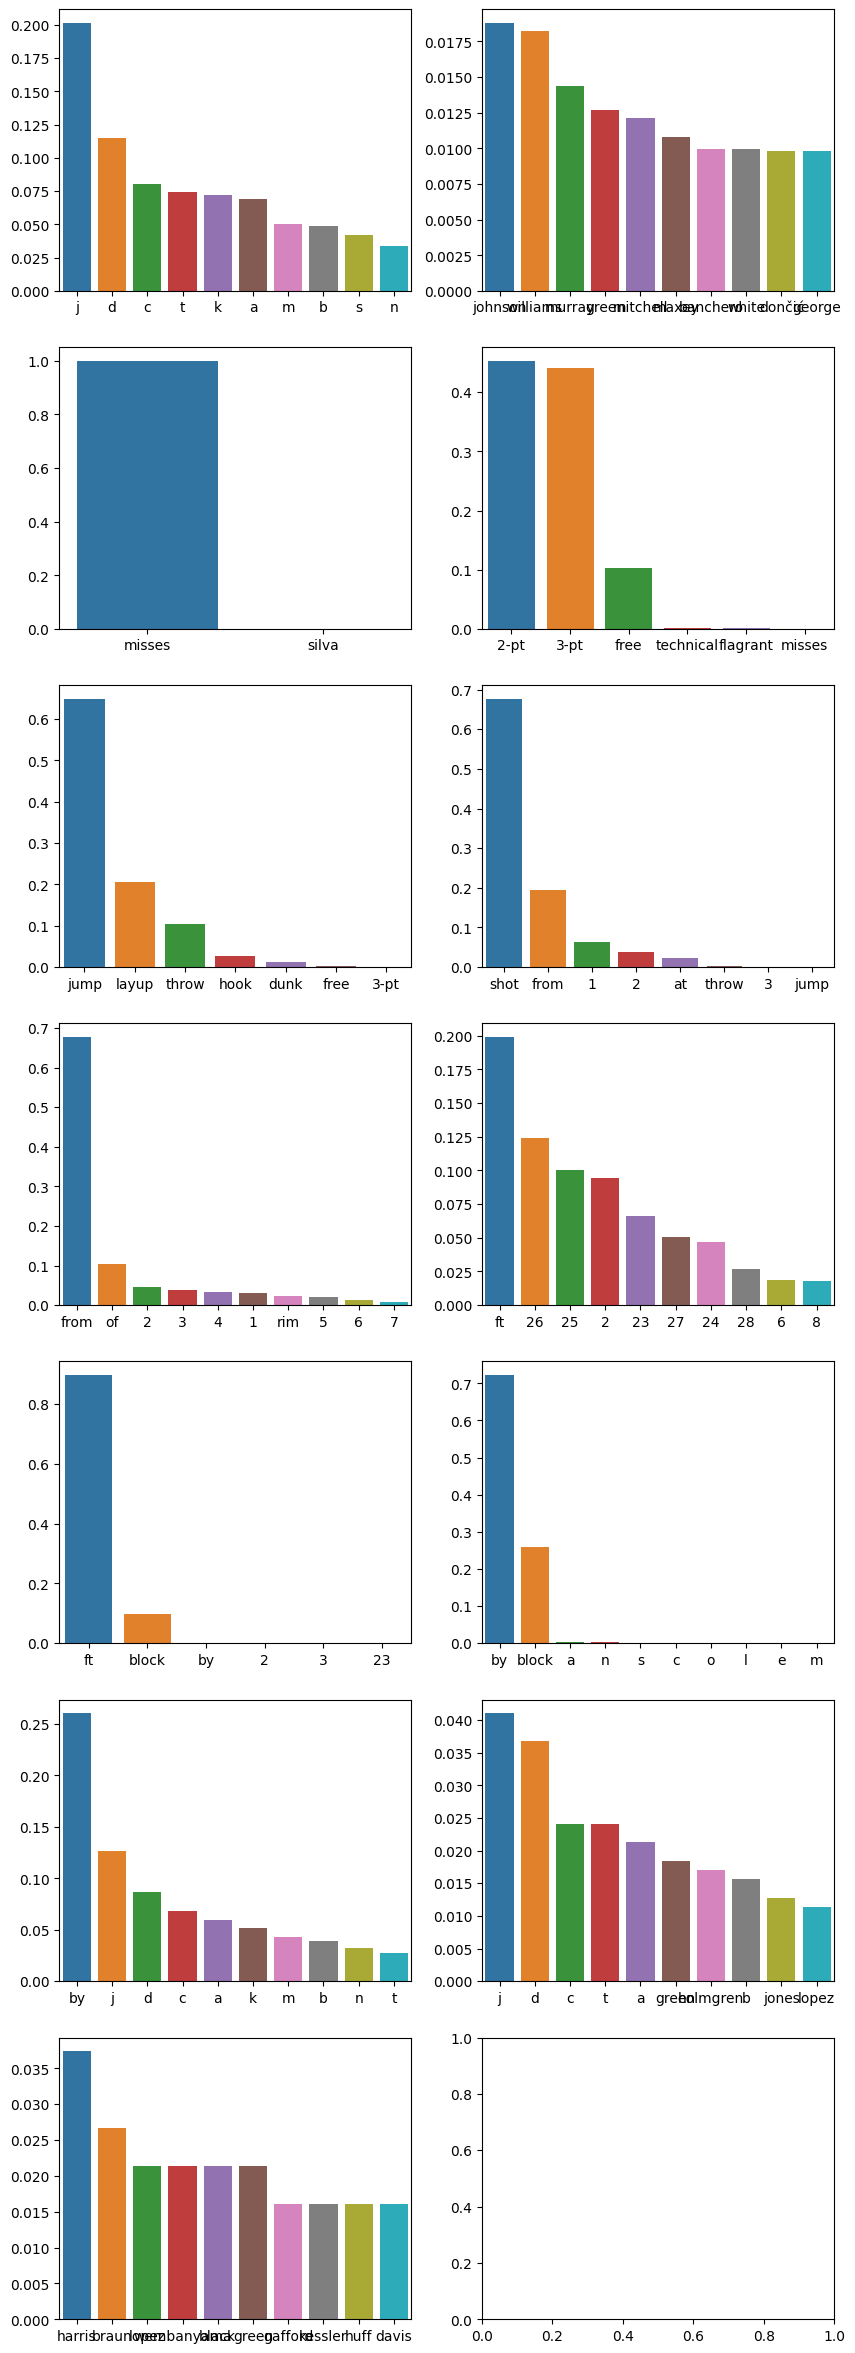

In [21]:
fig, axs = plt.subplots(nrows=math.ceil(len(columns_misses_list)/2), ncols=2, figsize=(10, 30))

# Loop para criar os gráficos
for n, col in enumerate(columns_misses_list):
    
    # Converter o índice 'n' em índices de linha e coluna
    row = n // 2
    col_idx = n % 2
    
    top5_words = misses_df[col].value_counts(normalize=True)[0:10]
    sns.barplot(x=top5_words.index, y=top5_words.values, ax=axs[row, col_idx])

In [22]:
misses_df[misses_df['word3'] == "silva"]

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,word11,word12


### Palavras a serem adicionadas

In [23]:
# Colunas necessárias 
pbp_tab_data['BLK'] = []
pbp_tab_data['BLK_by'] = []
pbp_tab_data['BLK_to'] = []

pbp_tab_data

{'key': [],
 'quarter': [],
 'time': [],
 'team': [],
 'player': [],
 'PTS': [],
 '2PA': [],
 '2PM': [],
 '3PA': [],
 '3PM': [],
 'FTA': [],
 'FTM': [],
 'DUNK': [],
 'LAYUP': [],
 'HOOK': [],
 'JUMP': [],
 'shoot_dist': [],
 'AST': [],
 'AST_by': [],
 'AST_to': [],
 'technical': [],
 'flagrant': [],
 'clear_path': [],
 'BLK': [],
 'BLK_by': [],
 'BLK_to': []}

## Rebotes

In [24]:
rebound_list = wanted_word_list(plays_list, 'rebound')
max_words_rebound_list = find_max_words(rebound_list)
columns_rebound_list = columns_def(max_words_rebound_list)

In [25]:
rebound_df = pd.DataFrame(rebound_list, columns=columns_rebound_list)
rebound_df

,word0,word1,word2,word3,word4
0,defensive,rebound,by,j,giddey
1,offensive,rebound,by,n,vučević
2,defensive,rebound,by,p,banchero
3,defensive,rebound,by,p,banchero
4,defensive,rebound,by,p,banchero
...,...,...,...,...,...
7014,offensive,rebound,by,w,kessler
7015,offensive,rebound,by,team,None
7016,defensive,rebound,by,s,aldama
7017,offensive,rebound,by,team,None


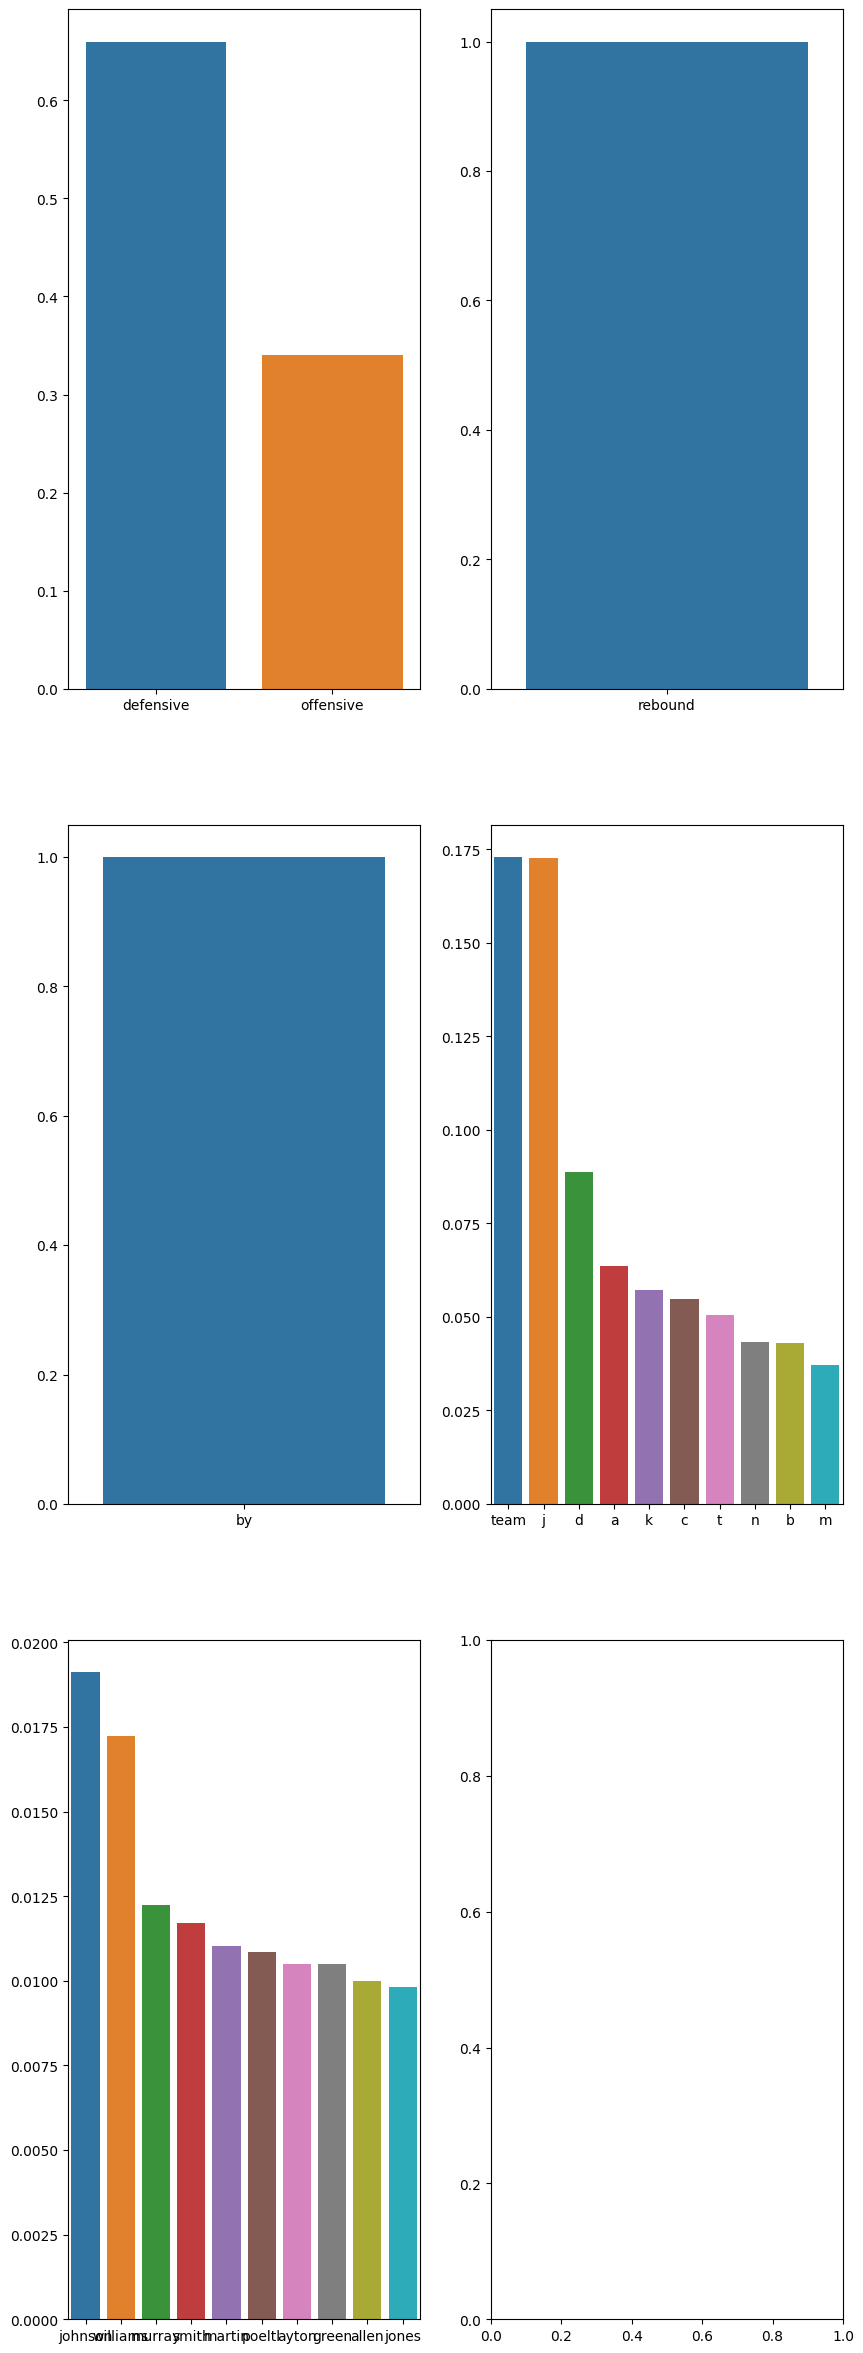

In [26]:
fig, axs = plt.subplots(nrows=math.ceil(len(columns_rebound_list)/2), ncols=2, figsize=(10, 30))

# Loop para criar os gráficos
for n, col in enumerate(columns_rebound_list):
    
    # Converter o índice 'n' em índices de linha e coluna
    row = n // 2
    col_idx = n % 2
    
    top5_words = rebound_df[col].value_counts(normalize=True)[0:10]
    sns.barplot(x=top5_words.index, y=top5_words.values, ax=axs[row, col_idx])

### Palavras a serem adicionadas

In [27]:
# Colunas necessárias 
pbp_tab_data['ORB'] = []
pbp_tab_data['DRB'] = []

pbp_tab_data

{'key': [],
 'quarter': [],
 'time': [],
 'team': [],
 'player': [],
 'PTS': [],
 '2PA': [],
 '2PM': [],
 '3PA': [],
 '3PM': [],
 'FTA': [],
 'FTM': [],
 'DUNK': [],
 'LAYUP': [],
 'HOOK': [],
 'JUMP': [],
 'shoot_dist': [],
 'AST': [],
 'AST_by': [],
 'AST_to': [],
 'technical': [],
 'flagrant': [],
 'clear_path': [],
 'BLK': [],
 'BLK_by': [],
 'BLK_to': [],
 'ORB': [],
 'DRB': []}

## Turnover

In [28]:
tov_list = wanted_word_list(plays_list, 'turnover')
max_words_tov_list = find_max_words(tov_list)
columns_tov_list = columns_def(max_words_tov_list)

In [29]:
tov_df = pd.DataFrame(tov_list, columns=columns_tov_list)
tov_df

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10
0,turnover,by,j,suggs,bad,pass,steal,by,z,lavine,None
1,turnover,by,z,lavine,lost,ball,steal,by,j,suggs,None
2,turnover,by,z,lavine,bad,pass,steal,by,k,caldwell-pope,None
3,turnover,by,j,suggs,bad,pass,steal,by,j,phillips,None
4,turnover,by,z,lavine,bad,pass,steal,by,j,suggs,None
...,...,...,...,...,...,...,...,...,...,...,...
1982,turnover,by,j,collins,lost,ball,steal,by,s,pippen,None
1983,turnover,by,c,williams,lost,ball,steal,by,j,morant,None
1984,turnover,by,s,pippen,bad,pass,None,None,None,None,None
1985,turnover,by,j,morant,lost,ball,steal,by,t,hendricks,None


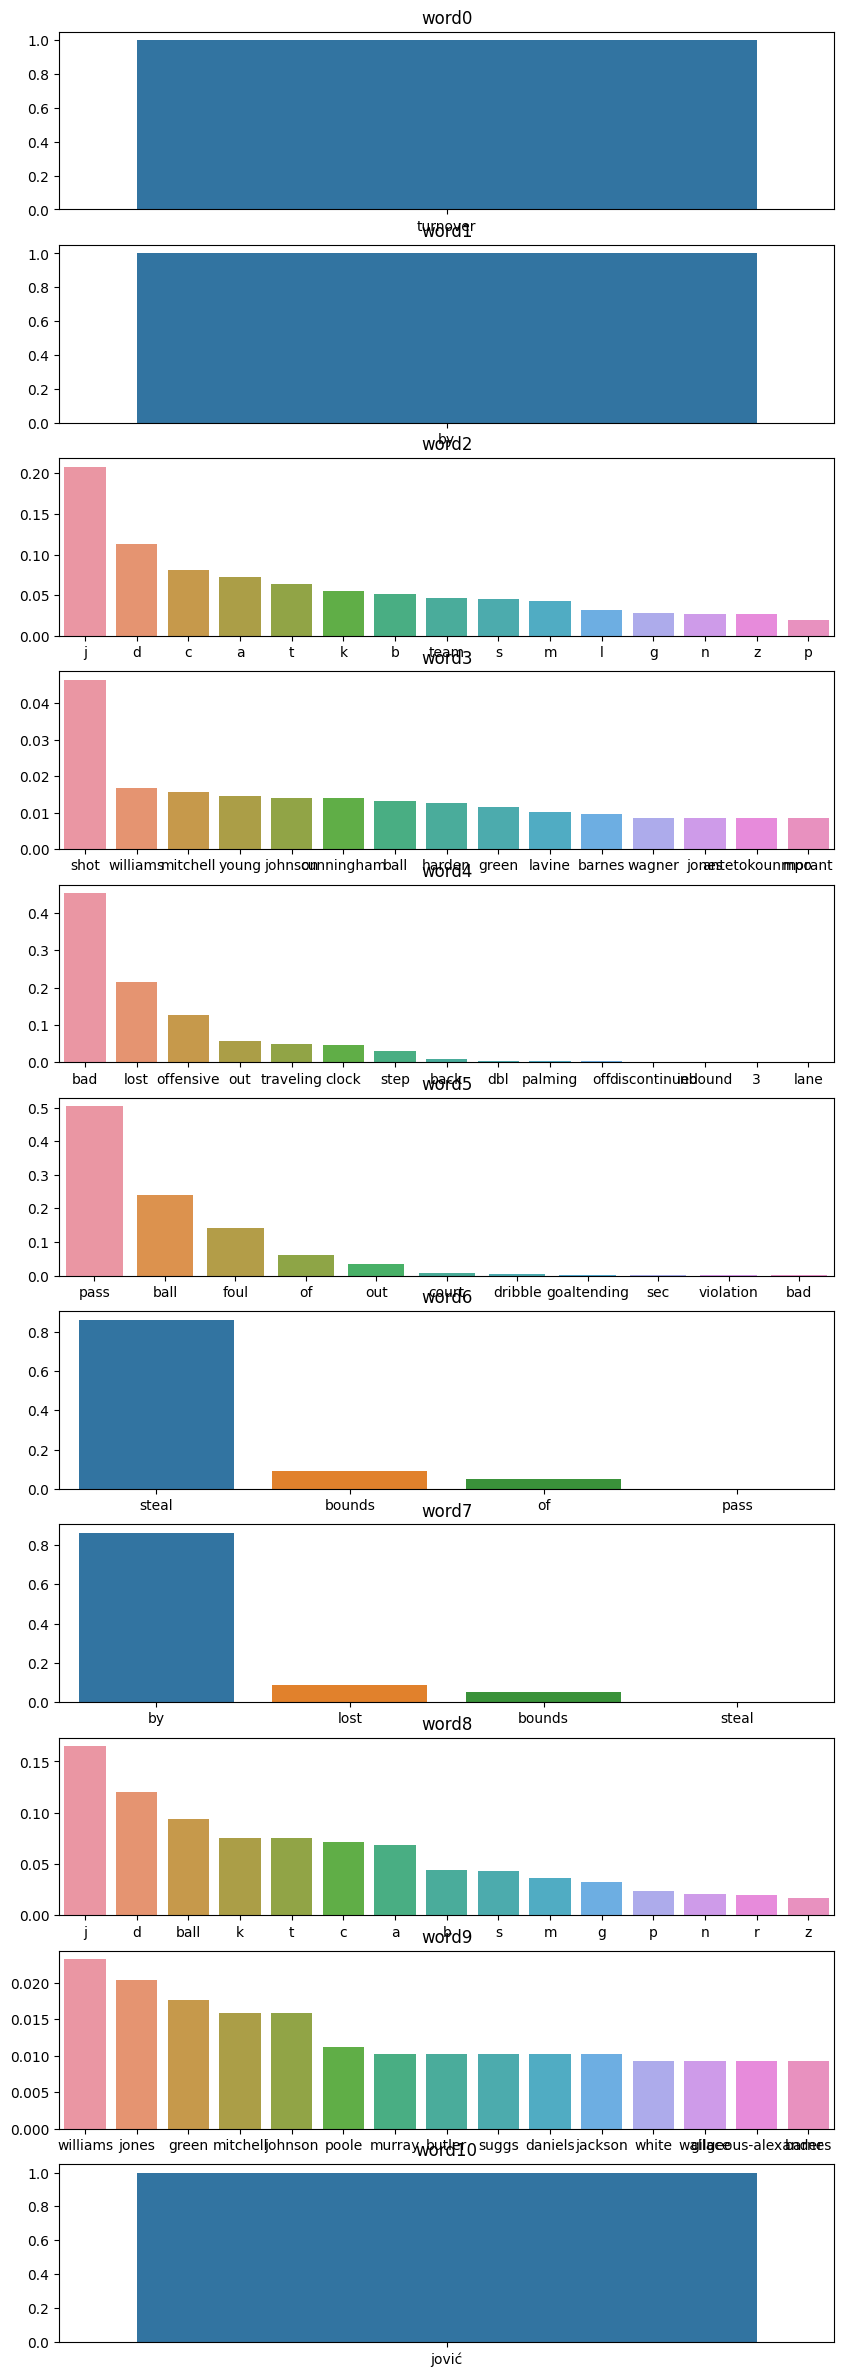

In [30]:
fig, axs = plt.subplots(nrows=math.ceil(len(columns_tov_list)), figsize=(10, 30))

# Loop para criar os gráficos
for n, col in enumerate(columns_tov_list):
    
    # Converter o índice 'n' em índices de linha e coluna
    row = n // 1
    
    top5_words = tov_df[col].value_counts(normalize=True)[0:15]
    sns.barplot(x=top5_words.index, y=top5_words.values, ax=axs[row])
    axs[row].set_title(col)

In [31]:
#tov_df[tov_df['word5'] == 'bad']

In [32]:
#tov_df[tov_df['word5'] == 'lost']

In [33]:
#tov_df[tov_df['word5'] == 'offensive']

In [34]:
#tov_df[tov_df['word5'] == 'traveling']

In [35]:
#tov_df[tov_df['word5'] == 'back']

In [36]:
#tov_df[tov_df['word5'] == 'step']

In [37]:
#tov_df[tov_df['word5'] == 'dbl']

In [38]:
#tov_df[tov_df['word5'] == 'off']

In [39]:
#tov_df[tov_df['word5'] == 'discontinued']

In [40]:
#tov_df[tov_df['word5'] == 'palming']

In [41]:
#tov_df[tov_df['word5'] == '3']

In [42]:
#tov_df[tov_df['word5'] == 'inbound']

In [43]:
#tov_df[tov_df['word5'] == 'lane']

In [44]:
#tov_df[tov_df['word7'] == 'bounds']

In [45]:
#tov_df[tov_df['word8'] == 'bounds']

In [46]:
#tov_df[tov_df['word8'] == 'lost']

### Palavras adicionadas

In [47]:
pbp_tab_data['TOV'] = []
pbp_tab_data['bad_pass'] = []
pbp_tab_data['lost_ball'] = []
pbp_tab_data['PF'] = []
pbp_tab_data['offensive_foul'] = []
pbp_tab_data['offensive_draw'] = []
pbp_tab_data['travelling'] = []
pbp_tab_data['back_court'] = []
pbp_tab_data['dbl_dribbling'] = []
pbp_tab_data['palming'] = []
pbp_tab_data['off_goaltending'] = []
pbp_tab_data['disc_dribbling'] = []
pbp_tab_data['out_of_bounds'] = []
pbp_tab_data['step_out_of_bounds'] = []
pbp_tab_data['off_3_sec'] = []
pbp_tab_data['inbound'] = []
pbp_tab_data['lane_violation'] = []
pbp_tab_data['STL'] = []
pbp_tab_data['STL_by'] = []
pbp_tab_data['STL_to'] = []

pbp_tab_data

{'key': [],
 'quarter': [],
 'time': [],
 'team': [],
 'player': [],
 'PTS': [],
 '2PA': [],
 '2PM': [],
 '3PA': [],
 '3PM': [],
 'FTA': [],
 'FTM': [],
 'DUNK': [],
 'LAYUP': [],
 'HOOK': [],
 'JUMP': [],
 'shoot_dist': [],
 'AST': [],
 'AST_by': [],
 'AST_to': [],
 'technical': [],
 'flagrant': [],
 'clear_path': [],
 'BLK': [],
 'BLK_by': [],
 'BLK_to': [],
 'ORB': [],
 'DRB': [],
 'TOV': [],
 'bad_pass': [],
 'lost_ball': [],
 'PF': [],
 'offensive_foul': [],
 'offensive_draw': [],
 'travelling': [],
 'back_court': [],
 'dbl_dribbling': [],
 'palming': [],
 'off_goaltending': [],
 'disc_dribbling': [],
 'out_of_bounds': [],
 'step_out_of_bounds': [],
 'off_3_sec': [],
 'inbound': [],
 'lane_violation': [],
 'STL': [],
 'STL_by': [],
 'STL_to': []}

## Foul

In [48]:
foul_list = wanted_word_list(plays_list, 'foul')
max_words_foul_list = find_max_words(foul_list)
columns_foul_list = columns_def(max_words_foul_list)

In [49]:
foul_df = pd.DataFrame(foul_list, columns=columns_foul_list)
foul_df

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10
0,shooting,foul,by,j,suggs,drawn,by,p,williams,None,None
1,shooting,foul,by,p,banchero,drawn,by,z,lavine,None,None
2,personal,foul,by,f,wagner,drawn,by,z,lavine,None,None
3,shooting,foul,by,j,giddey,drawn,by,p,banchero,None,None
4,shooting,foul,by,a,sanogo,drawn,by,m,wagner,None,None
...,...,...,...,...,...,...,...,...,...,...,...
3107,personal,foul,by,j,morant,drawn,by,c,sexton,None,None
3108,personal,foul,by,m,smart,drawn,by,c,sexton,None,None
3109,shooting,foul,by,j,huff,drawn,by,k,george,None,None
3110,shooting,foul,by,m,smart,drawn,by,k,george,None,None


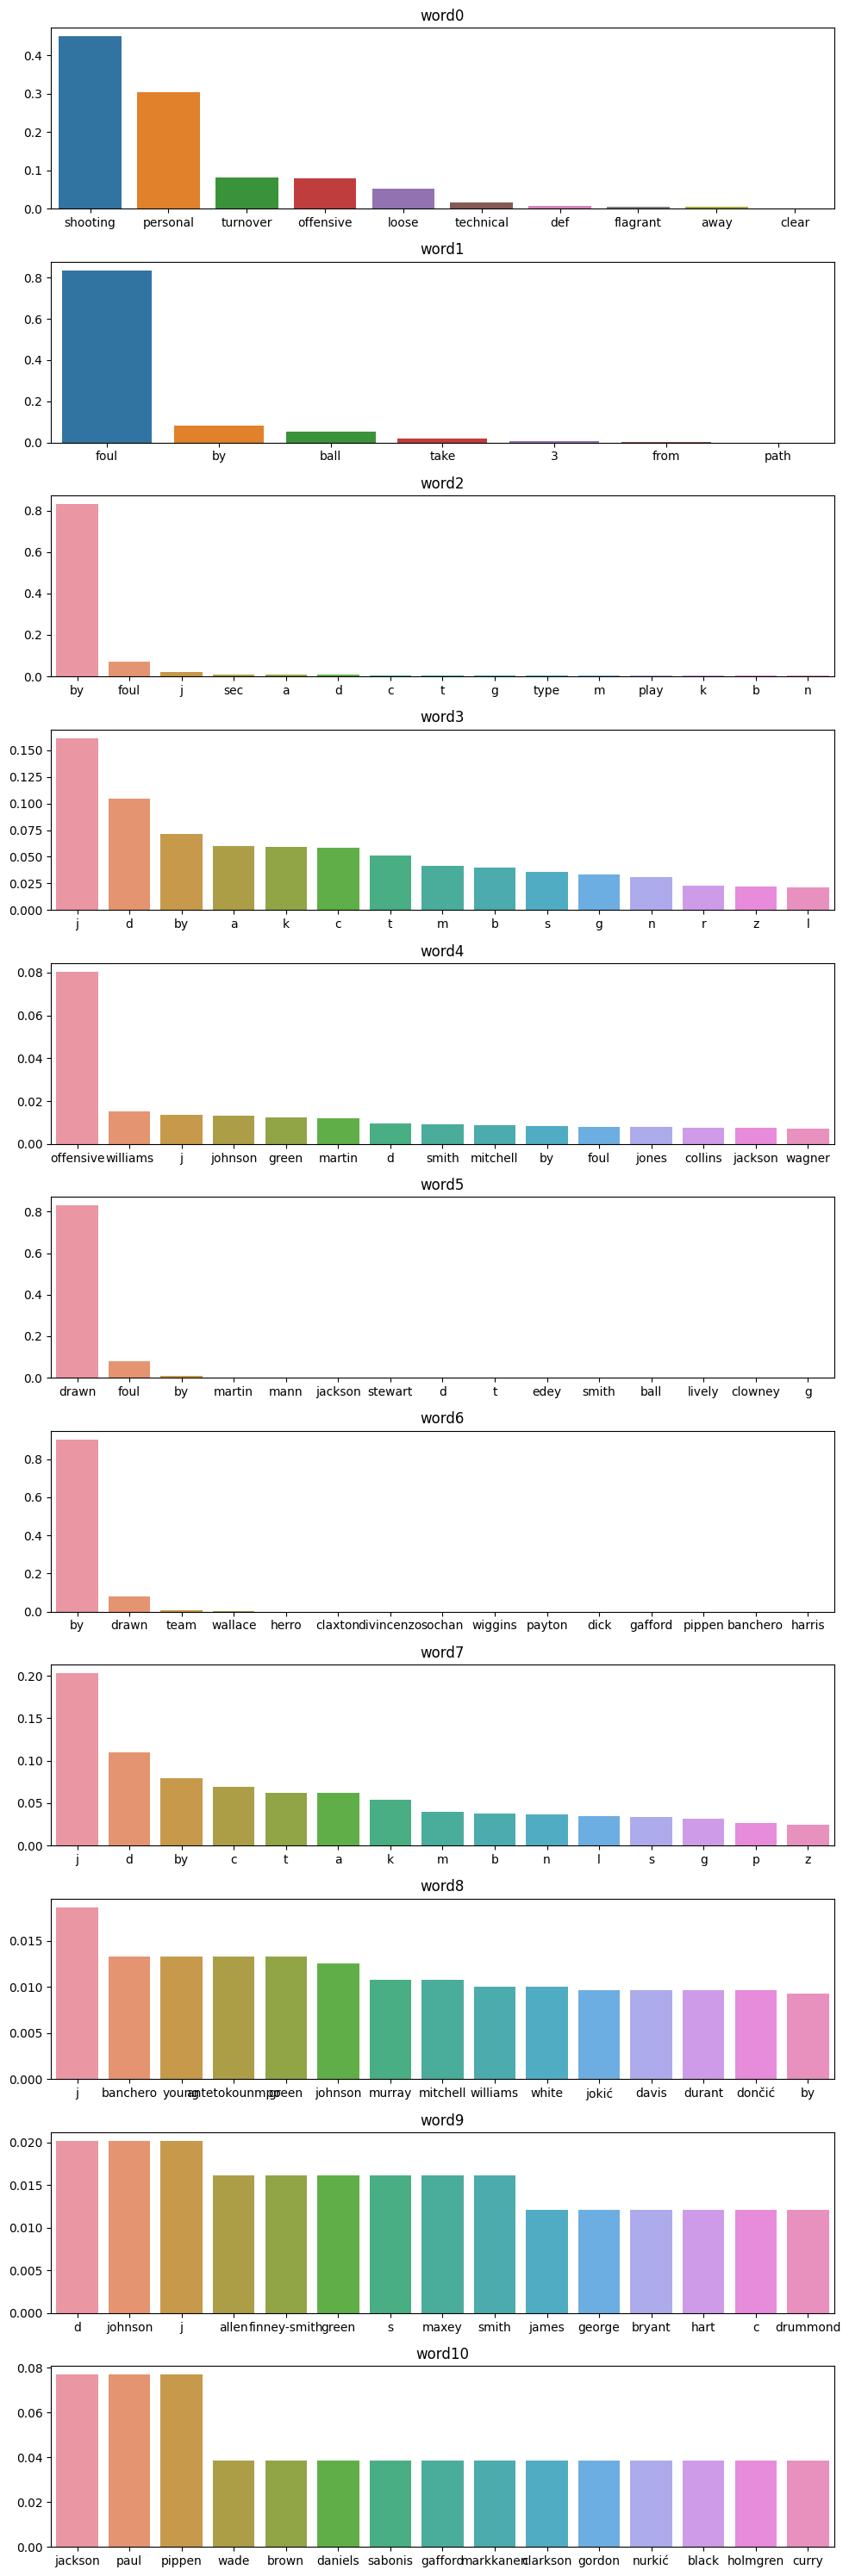

In [50]:
fig, axs = plt.subplots(nrows=math.ceil(len(columns_foul_list)), figsize=(10, 30))

# Loop para criar os gráficos
for n, col in enumerate(columns_foul_list):
    
    # Converter o índice 'n' em índices de linha e coluna
    row = n // 1
    
    top5_words = foul_df[col].value_counts(normalize=True)[0:15]
    sns.barplot(x=top5_words.index, y=top5_words.values, ax=axs[row])
    axs[row].set_title(col)
    
plt.tight_layout()  # Para melhorar a disposição dos gráficos
plt.show()

In [51]:
#foul_df[foul_df['word1'] == 'shooting']

In [52]:
#foul_df[foul_df['word1'] == 'personal']

In [53]:
#foul_df[foul_df['word1'] == 'offensive']

In [54]:
#foul_df[foul_df['word1'] == 'loose']

In [55]:
#foul_df[foul_df['word1'] == 'technical']

In [56]:
#foul_df[foul_df['word1'] == 'flagrant']

In [57]:
#foul_df[foul_df['word1'] == 'def']

In [58]:
#foul_df[foul_df['word1'] == 'away']

In [59]:
#foul_df[foul_df['word1'] == 'clear']

### Palavras adicionadas

In [60]:
pbp_tab_data['shooting_foul'] = []
pbp_tab_data['shooting_foul_draw'] = []
pbp_tab_data['personal_foul'] = []
pbp_tab_data['personal_foul_draw'] = []
pbp_tab_data['personal_take_foul'] = []
pbp_tab_data['personal_take_foul_draw'] = []
pbp_tab_data['loose_ball_foul'] = []
pbp_tab_data['loose_ball_foul_draw'] = []
pbp_tab_data['technical_foul'] = []
pbp_tab_data['flagrant_1_foul'] = []
pbp_tab_data['flagrant_1_foul_draw'] = []
pbp_tab_data['flagrant_2_foul'] = []
pbp_tab_data['flagrant_2_foul_draw'] = []
pbp_tab_data['def_3_sec'] = []
pbp_tab_data['away_from_play_foul'] = []
pbp_tab_data['away_from_play_foul_draw'] = []
pbp_tab_data['clear_path_foul'] = []

pbp_tab_data

{'key': [],
 'quarter': [],
 'time': [],
 'team': [],
 'player': [],
 'PTS': [],
 '2PA': [],
 '2PM': [],
 '3PA': [],
 '3PM': [],
 'FTA': [],
 'FTM': [],
 'DUNK': [],
 'LAYUP': [],
 'HOOK': [],
 'JUMP': [],
 'shoot_dist': [],
 'AST': [],
 'AST_by': [],
 'AST_to': [],
 'technical': [],
 'flagrant': [],
 'clear_path': [],
 'BLK': [],
 'BLK_by': [],
 'BLK_to': [],
 'ORB': [],
 'DRB': [],
 'TOV': [],
 'bad_pass': [],
 'lost_ball': [],
 'PF': [],
 'offensive_foul': [],
 'offensive_draw': [],
 'travelling': [],
 'back_court': [],
 'dbl_dribbling': [],
 'palming': [],
 'off_goaltending': [],
 'disc_dribbling': [],
 'out_of_bounds': [],
 'step_out_of_bounds': [],
 'off_3_sec': [],
 'inbound': [],
 'lane_violation': [],
 'STL': [],
 'STL_by': [],
 'STL_to': [],
 'shooting_foul': [],
 'shooting_foul_draw': [],
 'personal_foul': [],
 'personal_foul_draw': [],
 'personal_take_foul': [],
 'personal_take_foul_draw': [],
 'loose_ball_foul': [],
 'loose_ball_foul_draw': [],
 'technical_foul': [],
 'fla

# Funçoes de Arremesso Feito

### Funções de apoio

In [61]:
# Funções para completar as colunas com zeros
def complete_row(stats_dict, rows):
    
    for i in list(stats_dict.keys())[5:]:
        if i not in rows:
            stats_dict[i].append(0)

In [62]:
# Cópia de dicionário para testar as funções
teste_dict = {}
for k in pbp_tab_data.keys():
    teste_dict[k] = []

In [63]:
df_teste = merge_df.copy()
df_teste

,key,quarter,time,score,team_play,play,away_team,home_team,clean_play
0,/boxscores/pbp/202410300CHI.html,Q1,11:44.0,3-0,Orlando Magic,K. Caldwell-Pope makes 3-pt jump shot from 26 ...,Orlando Magic,Chicago Bulls,"[k, caldwell-pope, makes, 3-pt, jump, shot, fr..."
1,/boxscores/pbp/202410300CHI.html,Q1,11:27.0,3-2,Chicago Bulls,J. Giddey makes 2-pt jump shot from 20 ft,Orlando Magic,Chicago Bulls,"[j, giddey, makes, 2-pt, jump, shot, from, 20,..."
2,/boxscores/pbp/202410300CHI.html,Q1,11:15.0,3-2,Orlando Magic,P. Banchero misses 2-pt jump shot from 6 ft,Orlando Magic,Chicago Bulls,"[p, banchero, misses, 2-pt, jump, shot, from, ..."
3,/boxscores/pbp/202410300CHI.html,Q1,11:12.0,3-2,Chicago Bulls,Defensive rebound by J. Giddey,Orlando Magic,Chicago Bulls,"[defensive, rebound, by, j, giddey]"
4,/boxscores/pbp/202410300CHI.html,Q1,11:01.0,3-2,Chicago Bulls,P. Williams misses 2-pt layup from 2 ft,Orlando Magic,Chicago Bulls,"[p, williams, misses, 2-pt, layup, from, 2, ft]"
...,...,...,...,...,...,...,...,...,...
31152,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,125-121,Memphis Grizzlies,D. Bane makes free throw 1 of 2,Memphis Grizzlies,Utah Jazz,"[d, bane, makes, free, throw, 1, of, 2]"
31153,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,126-121,Memphis Grizzlies,D. Bane makes free throw 2 of 2,Memphis Grizzlies,Utah Jazz,"[d, bane, makes, free, throw, 2, of, 2]"
31154,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,126-121,Utah Jazz,Utah full timeout,Memphis Grizzlies,Utah Jazz,"[utah, full, timeout]"
31155,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,126-121,Utah Jazz,C. Sexton enters the game for W. Kessler,Memphis Grizzlies,Utah Jazz,"[c, sexton, enters, the, game, for, w, kessler]"


## Funções de arremessos feitos

### Assistências

In [64]:
def AST(key, quarter, time, team_play, play, _dict, rows):
    
    _dict['AST_by'].append(' '.join([play[-2], play[-1]])) 
    rows.append('AST_by')
    complete_row(_dict, rows)

    #Completando as stats do jogador que deu a assisteência
    _dict['key'].append(key)
    _dict['quarter'].append(quarter)
    _dict['time'].append(time)
    _dict['team'].append(team_play)    
    _dict['player'].append(' '.join([play[-2], play[-1]]))
    _dict['AST'].append(1)
    _dict['AST_to'].append(' '.join([play[0], play[1]]))

    rows = ['AST', 'AST_to']
    complete_row(_dict, rows)

### Arremesso de 3 pontos

In [65]:
#função para pontuar arremessos de 3 pontos com ou sem assistência
def _3PM(key, quarter, time, team_play, play, _dict):
    
    #inputs iniciais
    _dict['key'].append(key)
    _dict['quarter'].append(quarter)
    _dict['time'].append(time)
    _dict['team'].append(team_play)    
    _dict['player'].append(' '.join([play[0], play[1]]))
    _dict['PTS'].append(3)
    _dict['3PA'].append(1)
    _dict['3PM'].append(1)
    _dict['JUMP'].append(1)
    _dict['shoot_dist'].append(play[7])
    
    rows = ['PTS','3PA','3PM','JUMP','shoot_dist' ]
    
    #checando se tem assistência
    if 'assist' in play:
         AST(key, quarter, time, team_play, play, _dict, rows)      
    else:
        complete_row(_dict, rows)

### Aremessos de 2 pontos

In [66]:
#Função para tabular jumpshots
def jump(_dict, play, rows):
    _dict['JUMP'].append(1)
    rows.append('JUMP')

    _dict['shoot_dist'].append(play[7])
    rows.append('shoot_dist')    

In [67]:
#Função para tabular hookshots
def hook(_dict, play, rows):
    _dict['HOOK'].append(1)
    rows.append('HOOK')

    _dict['shoot_dist'].append(play[7])
    rows.append('shoot_dist') 

In [68]:
#Função para tabular dunks
def dunk(_dict, play, rows):
    _dict['DUNK'].append(1)
    rows.append('DUNK')

    _dict['shoot_dist'].append(play[6])
    rows.append('shoot_dist')    

In [69]:
#Função para tabular layups
def layup(_dict, play, rows):
    _dict['LAYUP'].append(1)
    rows.append('LAYUP')

    _dict['shoot_dist'].append(play[6])
    rows.append('shoot_dist') 

In [70]:
def _2PM(key, quarter, time, team_play, play, _dict):
    
    #inputs iniciais
    _dict['key'].append(key)
    _dict['quarter'].append(quarter)
    _dict['time'].append(time)
    _dict['team'].append(team_play)    
    _dict['player'].append(' '.join([play[0], play[1]]))
    _dict['PTS'].append(2)
    _dict['2PA'].append(1)
    _dict['2PM'].append(1)

    #rows com inputs
    rows = ['PTS','2PA','2PM']
    
    #checando tipo de arremesso
    if play[4] == 'jump':
        jump(_dict, play, rows)
   
    if play[4] == 'hook':
        hook(_dict, play, rows)   
    
    if play[4] == 'dunk':
        dunk(_dict, play, rows)

    if play[4] == 'layup':
        layup(_dict, play, rows)

        
    #checando se tem assistência
    if 'assist' in play:
         AST(key, quarter, time, team_play, play, _dict, rows)      
    else:
        complete_row(_dict, rows)

### Arremesso livre

In [71]:
def FT(key, quarter, time, team_play, play, _dict):
    
    #inputs iniciais
    _dict['key'].append(key)
    _dict['quarter'].append(quarter)
    _dict['time'].append(time)
    _dict['team'].append(team_play)    
    _dict['player'].append(' '.join([play[0], play[1]]))
    _dict['PTS'].append(1)
    _dict['FTA'].append(1)
    _dict['FTM'].append(1)
    
    #rows com inputs
    rows = ['PTS','FTA','FTM']    
    
    if play[3] == 'technical':
        _dict['technical'].append(1)
        rows.append('technical')
        
    if play[3] == 'flagrant':
        _dict['flagrant'].append(1)
        rows.append('flagrant')
    
    if play[3] == 'clear':
        _dict['clear_path'].append(1)
        rows.append('clear_path')
        
    complete_row(_dict, rows)

### Complicação das funções

In [72]:
def makes(key, quarter, time, team_play, play, _dict):
    
    if play[3] == '2-pt':
        _2PM(key, quarter, time, team_play, play, _dict)
    elif play[3] == '3-pt':
        _3PM(key, quarter, time, team_play, play, _dict) 
    else:
        FT(key, quarter, time, team_play, play, _dict)

### Teste de acurácia

In [ ]:
teste_dict = {}
for k in pbp_tab_data.keys():
    teste_dict[k] = []

In [75]:
#Aplicando a formula de makes nos jogos da última semana
for i in range(len(df_teste)):
    
    key = df_teste.iloc[i,:]['key']
    quarter = df_teste.iloc[i,:]['quarter']
    time = df_teste.iloc[i,:]['time']
    team_play = df_teste.iloc[i,:]['team_play']
    away_team = df_teste.iloc[i,:]['away_team']
    home_team = df_teste.iloc[i,:]['home_team']
    play = df_teste.iloc[i,:]['clean_play']  
    
    if len(play) < 3:
        continue
    
    if play[2] == 'makes':
        makes(key, quarter, time, team_play, play, teste_dict)
    

In [76]:
#Criando um dataframe
tab_df = pd.DataFrame(teste_dict)
tab_df

,key,quarter,time,team,player,PTS,2PA,2PM,3PA,3PM,...,loose_ball_foul_draw,technical_foul,flagrant_1_foul,flagrant_1_foul_draw,flagrant_2_foul,flagrant_2_foul_draw,def_3_sec,away_from_play_foul,away_from_play_foul_draw,clear_path_foul
0,/boxscores/pbp/202410300CHI.html,Q1,11:44.0,Orlando Magic,k caldwell-pope,3,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,/boxscores/pbp/202410300CHI.html,Q1,11:44.0,Orlando Magic,p banchero,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/boxscores/pbp/202410300CHI.html,Q1,11:27.0,Chicago Bulls,j giddey,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/boxscores/pbp/202410300CHI.html,Q1,10:23.0,Orlando Magic,p banchero,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/boxscores/pbp/202410300CHI.html,Q1,10:23.0,Orlando Magic,w carter,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11115,/boxscores/pbp/202410230UTA.html,Q4,0:33.0,Utah Jazz,k george,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11116,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,Memphis Grizzlies,d bane,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11117,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,Memphis Grizzlies,d bane,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11118,/boxscores/pbp/202410230UTA.html,Q4,0:04.0,Utah Jazz,l markkanen,3,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Criando uma DF temporária para checar se encontro alguma diferença no placar dos jogos

In [77]:
#dicionário de apoio para comparaçao de resultados
tab_conf = {
    'key' : [],
    'team1': [],
    'score_1': [],
    'team2': [],
    'score_2': [],
}

In [78]:
#Selecioonando apenas as colunas desejadas para a criação de uma df
test_key = tab_df.key.unique()
for i in test_key:
   
    #agrupando separando uma df pra cada jogo e agrupando os time para ter o plcacar final
    tab_conf['key'].append(i)
    temp_df = tab_df[tab_df['key'] == i]
    temp_df = temp_df.groupby(temp_df['team'], as_index=False).sum()
    
    #coletando o placar do jogo
    tab_conf['team1'].append(temp_df.iloc[0,:].team)
    tab_conf['score_1'].append(temp_df.iloc[0,:].PTS)
    tab_conf['team2'].append(temp_df.iloc[1,:].team)
    tab_conf['score_2'].append(temp_df.iloc[1,:].PTS)    

In [79]:
tab_conf_df = pd.DataFrame(tab_conf)
tab_conf_df = tab_conf_df.merge(games_df[['key', 
            'away_team', 'away_team_score', 'home_team', 'home_team_score']],on='key')
tab_conf_df

,key,team1,score_1,team2,score_2,away_team,away_team_score,home_team,home_team_score
0,/boxscores/pbp/202410300CHI.html,Chicago Bulls,102,Orlando Magic,99,Orlando Magic,99,Chicago Bulls,102
1,/boxscores/pbp/202410300CHO.html,Charlotte Hornets,138,Toronto Raptors,133,Toronto Raptors,133,Charlotte Hornets,138
2,/boxscores/pbp/202410300CLE.html,Cleveland Cavaliers,134,Los Angeles Lakers,110,Los Angeles Lakers,110,Cleveland Cavaliers,134
3,/boxscores/pbp/202410300GSW.html,Golden State Warriors,104,New Orleans Pelicans,89,New Orleans Pelicans,89,Golden State Warriors,104
4,/boxscores/pbp/202410300IND.html,Boston Celtics,132,Indiana Pacers,135,Boston Celtics,132,Indiana Pacers,135
...,...,...,...,...,...,...,...,...,...
60,/boxscores/pbp/202410230NOP.html,Chicago Bulls,111,New Orleans Pelicans,123,Chicago Bulls,111,New Orleans Pelicans,123
61,/boxscores/pbp/202410230PHI.html,Milwaukee Bucks,124,Philadelphia 76ers,109,Milwaukee Bucks,124,Philadelphia 76ers,109
62,/boxscores/pbp/202410230POR.html,Golden State Warriors,140,Portland Trail Blazers,104,Golden State Warriors,140,Portland Trail Blazers,104
63,/boxscores/pbp/202410230TOR.html,Cleveland Cavaliers,136,Toronto Raptors,106,Cleveland Cavaliers,136,Toronto Raptors,106


In [80]:
games_df[['key', 'away_team', 'away_team_score', 'home_team', 'home_team_score']].sort_values(by='key').head(40)
tab_conf_df['tab_conf_sum'] = (tab_conf_df['score_1'] 
                               + tab_conf_df['score_2']) - (tab_conf_df['away_team_score'] + tab_conf_df['home_team_score'])

In [81]:
tab_conf_df['tab_conf_sum'].value_counts()

0    65
Name: tab_conf_sum, dtype: int64

 Todos os jogos tem o mesmo placar

## Arremessos perdidos

### Bloqueios

In [82]:
# Função pra atribuição de bloqueios
def BLK(key, quarter, time, team_play, away_team, home_team, play, _dict, rows):
    
    _dict['BLK_by'].append(' '.join([play[-2], play[-1]])) 
    rows.append('BLK_by')
    complete_row(_dict, rows)

    #Completando as stats do jogador que deu a assisteência
    _dict['key'].append(key)
    _dict['quarter'].append(quarter)
    _dict['time'].append(time)
    _dict['player'].append(' '.join([play[-2], play[-1]]))
    
    #Definindo no time do jogador
    if team_play == home_team:
        _dict['team'].append(away_team)  
    else:
        _dict['team'].append(home_team)  
    
    _dict['BLK'].append(1)
    _dict['BLK_to'].append(' '.join([play[0], play[1]]))

    rows = ['BLK', 'BLK_to']
    complete_row(_dict, rows)

### Arremessos de 3-Pt perdidos

In [83]:
def _3PA(key, quarter, time, team_play, away_team, home_team, play, _dict):
    
    #inputs iniciais
    _dict['key'].append(key)
    _dict['quarter'].append(quarter)
    _dict['time'].append(time)
    _dict['team'].append(team_play)    
    _dict['player'].append(' '.join([play[0], play[1]]))
    _dict['3PA'].append(1)
    _dict['JUMP'].append(1)
    _dict['shoot_dist'].append(play[7])
    
    rows = ['3PA','JUMP','shoot_dist' ]
    
    #checando se tem toco
    if 'block' in play:
         BLK(key, quarter, time, team_play, away_team, home_team, play, _dict, rows)    
    else:
        complete_row(_dict, rows)

### Arremessos de 2-pt perdido

In [84]:
def _2PA(key, quarter, time, team_play, away_team, home_team, play, _dict):
    
    #inputs iniciais
    _dict['key'].append(key)
    _dict['quarter'].append(quarter)
    _dict['time'].append(time)
    _dict['team'].append(team_play)    
    _dict['player'].append(' '.join([play[0], play[1]]))
    _dict['2PA'].append(1)

    #rows com inputs
    rows = ['2PA']
    
    #checando tipo de arremesso
    if play[4] == 'jump':
        jump(_dict, play, rows)
   
    if play[4] == 'hook':
        hook(_dict, play, rows)   
    
    if play[4] == 'dunk':
        dunk(_dict, play, rows)

    if play[4] == 'layup':
        layup(_dict, play, rows)

        
    #checando se tem toco
    if 'block' in play:
         BLK(key, quarter, time, team_play, away_team, home_team, play, _dict, rows)    
    else:
        complete_row(_dict, rows)

### Arremesso livre perdido

In [85]:
def FTA(key, quarter, time, team_play, away_team, home_team, play, _dict):
    
    #inputs iniciais
    _dict['key'].append(key)
    _dict['quarter'].append(quarter)
    _dict['time'].append(time)
    _dict['team'].append(team_play)    
    _dict['player'].append(' '.join([play[0], play[1]]))
    _dict['FTA'].append(1)
    
    #rows com inputs
    rows = ['FTA']    
    
    if play[3] == 'technical':
        _dict['technical'].append(1)
        rows.append('technical')
        
    if play[3] == 'flagrant':
        _dict['flagrant'].append(1)
        rows.append('flagrant')
    
    if play[3] == 'clear':
        _dict['clear_path'].append(1)
        rows.append('clear_path')
        
    complete_row(_dict, rows)

### Compilando formulas

In [86]:
def misses(key, quarter, time, team_play, away_team, home_team, play, _dict):
    
    if play[3] == '2-pt':
        _2PA(key, quarter, time, team_play, away_team, home_team, play, _dict)
    elif play[3] == '3-pt':
        _3PA(key, quarter, time, team_play, away_team, home_team, play, _dict) 
    else:
        FTA(key, quarter, time, team_play, away_team, home_team, play, _dict)

### Testando os dados

In [91]:
teste_dict = {}
for k in pbp_tab_data.keys():
    teste_dict[k] = []

In [92]:
#Aplicando a formula de makes nos jogos da última semana
for i in range(len(df_teste)):
    
    key = df_teste.iloc[i,:]['key']
    quarter = df_teste.iloc[i,:]['quarter']
    time = df_teste.iloc[i,:]['time']
    team_play = df_teste.iloc[i,:]['team_play']
    away_team = df_teste.iloc[i,:]['away_team']
    home_team = df_teste.iloc[i,:]['home_team']
    play = df_teste.iloc[i,:]['clean_play']  
    
    if len(play) < 3:
        continue
    
    if play[2] == 'makes':
        makes(key, quarter, time, team_play, play, teste_dict)
        
    if play[2] == 'misses':
        misses(key, quarter, time, team_play, away_team, home_team, play, teste_dict)

In [93]:
tab_df = pd.DataFrame(teste_dict)
tab_df

,key,quarter,time,team,player,PTS,2PA,2PM,3PA,3PM,...,loose_ball_foul_draw,technical_foul,flagrant_1_foul,flagrant_1_foul_draw,flagrant_2_foul,flagrant_2_foul_draw,def_3_sec,away_from_play_foul,away_from_play_foul_draw,clear_path_foul
0,/boxscores/pbp/202410300CHI.html,Q1,11:44.0,Orlando Magic,k caldwell-pope,3,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,/boxscores/pbp/202410300CHI.html,Q1,11:44.0,Orlando Magic,p banchero,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/boxscores/pbp/202410300CHI.html,Q1,11:27.0,Chicago Bulls,j giddey,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/boxscores/pbp/202410300CHI.html,Q1,11:15.0,Orlando Magic,p banchero,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/boxscores/pbp/202410300CHI.html,Q1,11:01.0,Chicago Bulls,p williams,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18851,/boxscores/pbp/202410230UTA.html,Q4,0:13.0,Memphis Grizzlies,d bane,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18852,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,Memphis Grizzlies,d bane,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18853,/boxscores/pbp/202410230UTA.html,Q4,0:06.0,Memphis Grizzlies,d bane,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18854,/boxscores/pbp/202410230UTA.html,Q4,0:04.0,Utah Jazz,l markkanen,3,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [102]:
#dicionário de apoio para comparaçao de resultados
tab_conf = {
    'key' : [],
    'team_1': [],
    '3PA_1': [],
    '3PM_1': [],
    'BLK_1': [],   
    'team_2': [],
    '3PA_2': [],
    '3PM_2': [],
    'BLK_2': []  
}

In [103]:
#Selecioonando apenas as colunas desejadas para a criação de uma df
test_key = tab_df.key.unique()
for i in test_key:
   
    #agrupando separando uma df pra cada jogo e agrupando os time para ter o plcacar final
    tab_conf['key'].append(i)
    temp_df = tab_df[tab_df['key'] == i]
    temp_df = temp_df.groupby(temp_df['team'], as_index=False).sum()
    
    #coletando o placar do jogo
    tab_conf['team_1'].append(temp_df.iloc[0,:].team)
    tab_conf['3PA_1'].append(temp_df.iloc[0,:]['3PA'])
    tab_conf['3PM_1'].append(temp_df.iloc[0,:]['3PM']) 
    tab_conf['BLK_1'].append(temp_df.iloc[0,:].BLK)     
    tab_conf['team_2'].append(temp_df.iloc[1,:].team)
    tab_conf['3PA_2'].append(temp_df.iloc[1,:]['3PA'])
    tab_conf['3PM_2'].append(temp_df.iloc[1,:]['3PM']) 
    tab_conf['BLK_2'].append(temp_df.iloc[1,:].BLK)      

In [106]:
tab_conf_df = pd.DataFrame(tab_conf)
tab_conf_df

,key,team_1,3PA_1,3PM_1,BLK_1,team_2,3PA_2,3PM_2,BLK_2
0,/boxscores/pbp/202410300CHI.html,Chicago Bulls,34,13,2,Orlando Magic,46,11,8
1,/boxscores/pbp/202410300CHO.html,Charlotte Hornets,45,20,8,Toronto Raptors,28,9,5
2,/boxscores/pbp/202410300CLE.html,Cleveland Cavaliers,41,17,2,Los Angeles Lakers,28,6,0
3,/boxscores/pbp/202410300GSW.html,Golden State Warriors,38,13,9,New Orleans Pelicans,36,11,6
4,/boxscores/pbp/202410300IND.html,Boston Celtics,57,19,5,Indiana Pacers,38,15,5
...,...,...,...,...,...,...,...,...,...
60,/boxscores/pbp/202410230NOP.html,Chicago Bulls,34,10,2,New Orleans Pelicans,37,14,10
61,/boxscores/pbp/202410230PHI.html,Milwaukee Bucks,37,16,9,Philadelphia 76ers,31,8,2
62,/boxscores/pbp/202410230POR.html,Golden State Warriors,48,20,5,Portland Trail Blazers,34,8,4
63,/boxscores/pbp/202410230TOR.html,Cleveland Cavaliers,30,14,9,Toronto Raptors,31,12,6


In [ ]:
df_teste

### Testes

In [ ]:
misses_df[misses_df['word3'] == "3-pt"]['word7'].value_counts()

In [ ]:
df_teste[df_teste['play'].str.contains('misses flagrant')]

In [ ]:
i = 1279
key = df_teste.iloc[i,:]['key']
quarter = df_teste.iloc[i,:]['quarter']
time = df_teste.iloc[i,:]['time']
team_play = df_teste.iloc[i,:]['team_play']
away_team = df_teste.iloc[i,:]['away_team']
home_team = df_teste.iloc[i,:]['home_team']
play = df_teste.iloc[i,:]['clean_play']
print(play)

In [ ]:
play[2]

In [ ]:
FTA(key, quarter, time, team_play, away_team, home_team, play, teste_dict)
teste_dict

In [ ]:
teste_dict = {}
for k in pbp_tab_data.keys():
    teste_dict[k] = []

In [ ]:
! git add .

! git commit -m "01/11/2024'